In [1]:
library(hexView)

In [2]:
library(plm)

All practical examples are built around Grunfeld’s Investment Data contained in R package plm. This dataset is a panel of 10 observational units (firms) from 1935 to 1954.

In [3]:
data("Grunfeld", package = "plm")

In [4]:
?Grunfeld

In [6]:
# Grunfeld 

In [7]:
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plm’:

    between, lag, lead


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [8]:
Grunfeld %>%
  is.pbalanced()

[1] TRUE

In [9]:
library(ggplot2)

A simple lineplot of gross investment (inv) over time (year) without taking into account the entity dimension does not give meaningful results!

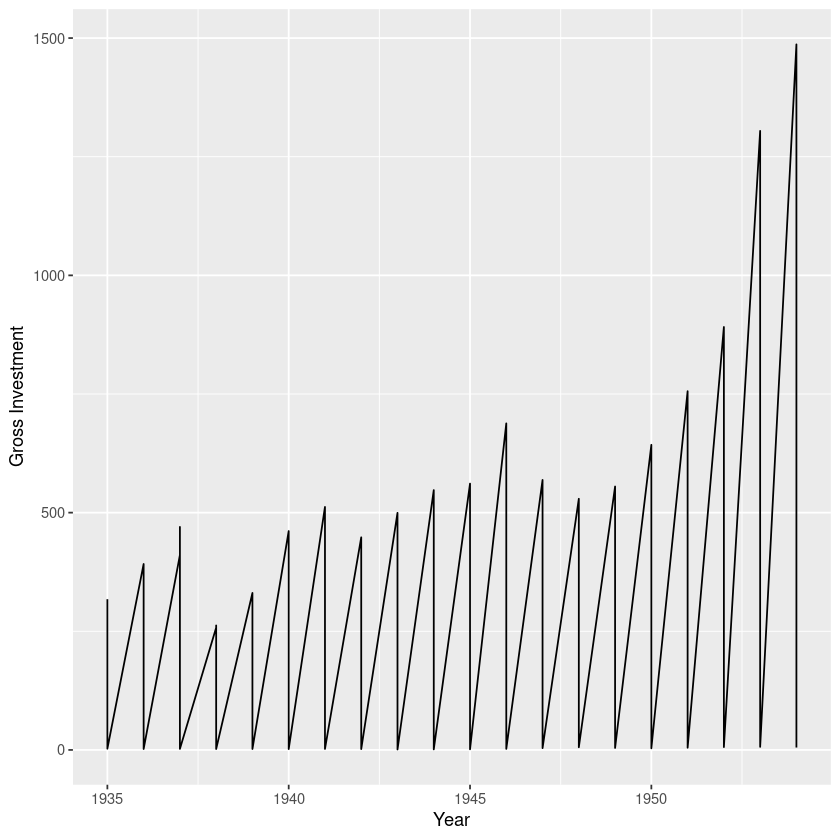

In [10]:
ggplot(data = Grunfeld, aes(x = year, y = inv)) +
  geom_line() +
  labs(x = "Year",  y = "Gross Investment") +
  theme(legend.position = "none")

Therefore, I create a line plot for each firm separated by colour. The additional blue dashed line indicates the overall trend in the data considering all firms simultaneously. It is in fact the fitted regression line of a linear model between inv and year. Firm 1 and 2 have a relatively high gross investment compared to the other firms. On average, gross investment increases over time.

`geom_smooth()` using formula = 'y ~ x'


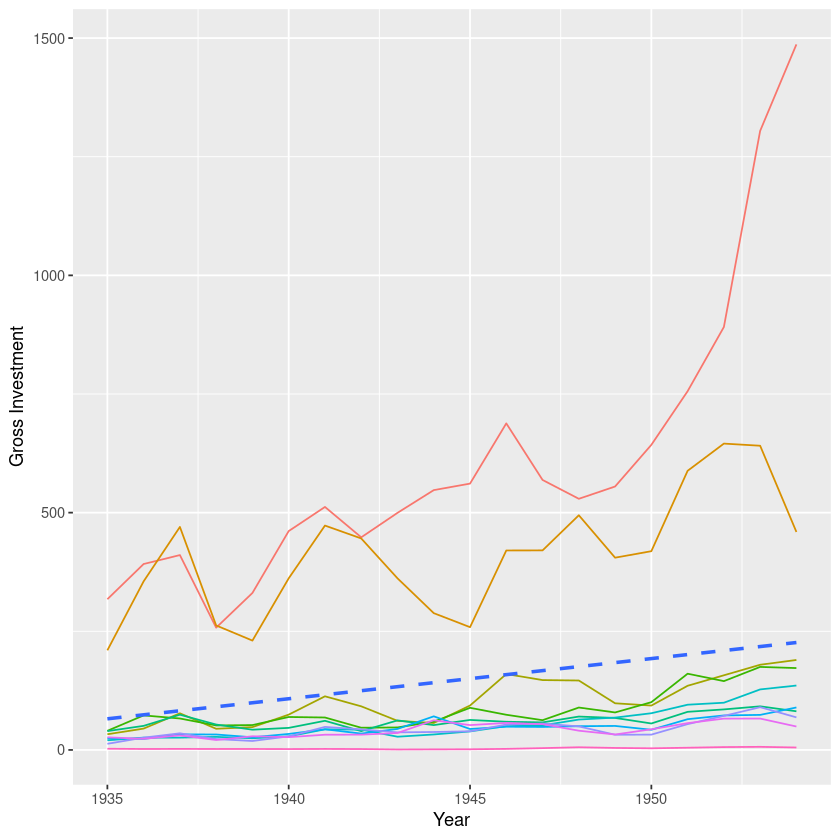

In [11]:
ggplot(data = Grunfeld, aes(x = year, y = inv)) +
  geom_line(aes(colour = as.factor(firm))) +
  geom_smooth(method = "lm", se = F, lty = "dashed") +
  labs(x = "Year",  y = "Gross Investment") +
  theme(legend.position = "none")

Heterogeneity across firms can be shown with a line plot. The blue line connects the mean values of inv, using all available years across firms (entities).

Joining, by = "firm"


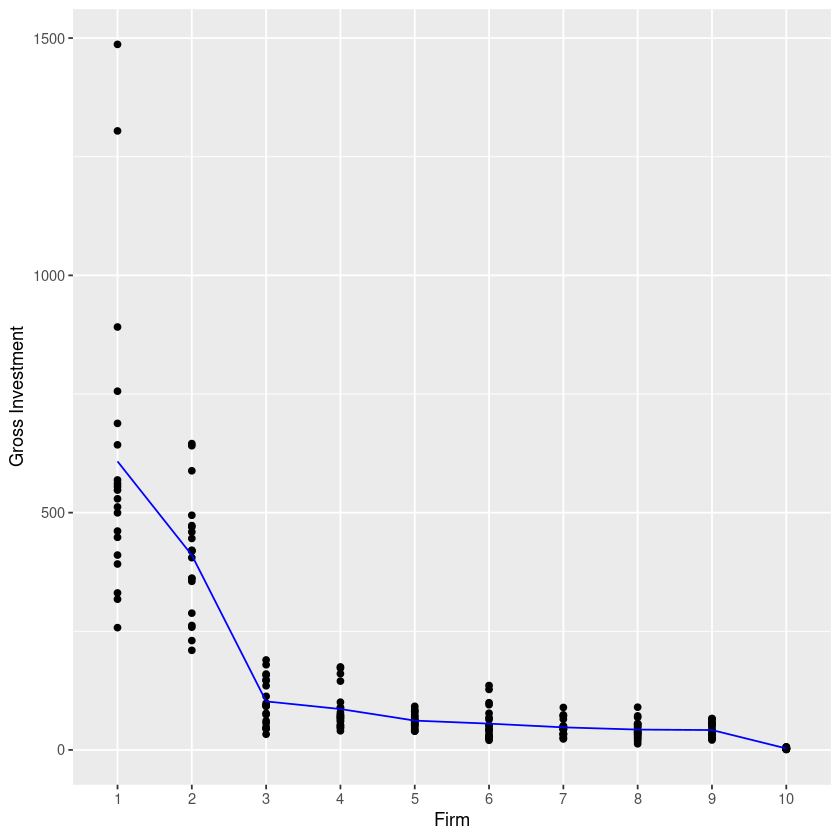

In [12]:
Grunfeld %>%
  group_by(firm) %>%
  summarise(inv_mean = mean(inv)) %>%
  left_join(Grunfeld) %>%
  ggplot(data = ., 
         aes(x = reorder(as.character(firm), firm), y = inv)) +
  geom_point() +
  geom_line(aes(x = firm, y = inv_mean), col = "blue") +
  labs(x = "Firm", y = "Gross Investment")

The same holds for the time dimension. Here the blue line connects the mean values of inv, using all available firms across years (time).

In [ ]:
Grunfeld %>%
  group_by(year) %>%
  summarise(inv_mean = mean(inv)) %>%
  left_join(Grunfeld) %>%
  ggplot(data = ., 
         aes(x = year, y = inv)) +
  geom_point() +
  geom_line(aes(x = year, y = inv_mean), col = "blue") +
  scale_x_continuous(labels = as.character(Grunfeld$year), 
                     breaks = Grunfeld$year) +
  labs(x = "Year", y = "Gross Investment") +
  theme(axis.text.x = element_text(angle = 90))

3.1 Pooled Cross Sections

In [13]:
pooled_ols_lm <- lm(inv ~ capital, data = Grunfeld )

summary(pooled_ols_lm)


Call:
lm(formula = inv ~ capital, data = Grunfeld)

Residuals:
    Min      1Q  Median      3Q     Max 
-316.92  -96.45  -14.43   17.07  481.92 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 14.23620   15.63927    0.91    0.364    
capital      0.47722    0.03834   12.45   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 162.9 on 198 degrees of freedom
Multiple R-squared:  0.439,	Adjusted R-squared:  0.4362 
F-statistic: 154.9 on 1 and 198 DF,  p-value: < 2.2e-16


We achieve the same coefficient estimates by using function plm() from package plm. First, an index has to be supplied, corresponding to the entity and/or time dimension of the panel. The argument model= is set to "pooling". Additional information about the dataset’s panel structure is shown at the top of the summary output. The Grunfeld data consists of 10 firms (n) measured at 20 time points (T) resulting in 200 observations in total (N).

In [14]:
pooled_ols_plm <- plm(inv ~ capital, data = Grunfeld, 
                      index = c("firm", "year"), 
                      effect = "individual", model = "pooling")

summary(pooled_ols_plm)

Pooling Model

Call:
plm(formula = inv ~ capital, data = Grunfeld, effect = "individual", 
    model = "pooling", index = c("firm", "year"))

Balanced Panel: n = 10, T = 20, N = 200

Residuals:
    Min.  1st Qu.   Median  3rd Qu.     Max. 
-316.924  -96.450  -14.429   17.069  481.924 

Coefficients:
             Estimate Std. Error t-value Pr(>|t|)    
(Intercept) 14.236205  15.639266  0.9103   0.3638    
capital      0.477224   0.038339 12.4474   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    9359900
Residual Sum of Squares: 5251000
R-Squared:      0.43899
Adj. R-Squared: 0.43616
F-statistic: 154.937 on 1 and 198 DF, p-value: < 2.22e-16

`geom_smooth()` using formula = 'y ~ x'


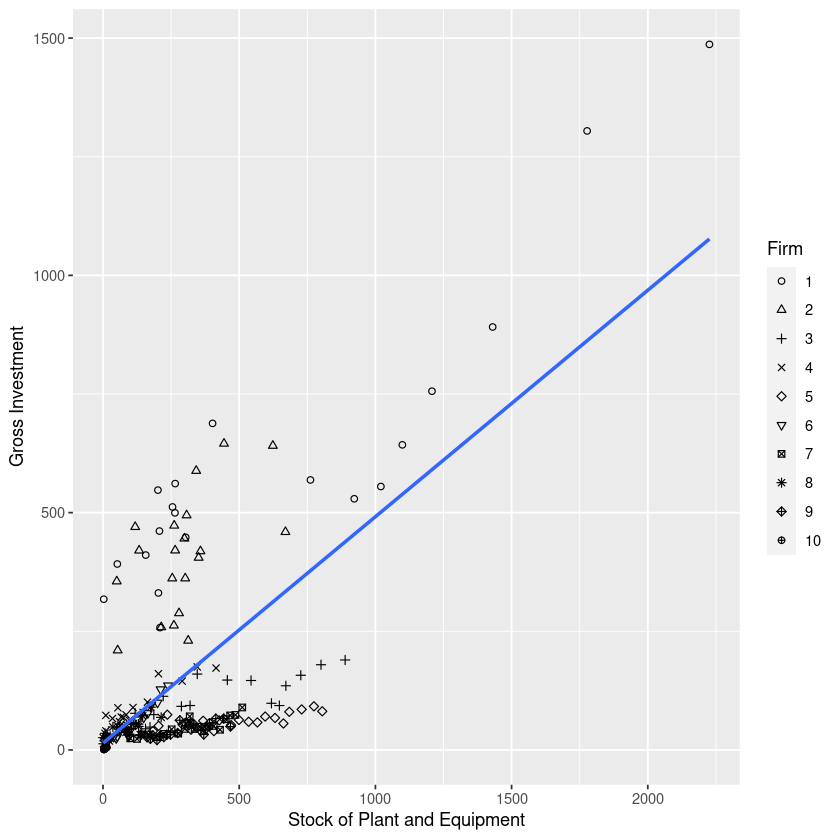

In [15]:
ggplot(data = Grunfeld,
       aes(x = capital, y = inv)) +
  geom_point(aes(shape = factor(firm, 
                                levels = c(1:10)))) +
  geom_smooth(method = "lm", se = F) +
  scale_shape_manual(values = 1:10) +
  labs(x = "Stock of Plant and Equipment",
       y = "Gross Investment",
       shape = "Firm")

The fixed effects (FE) model, also called within estimator or least squares dummy variable (LSDV) model, is commonly applied to remove omitted variable bias. By estimating changes within a specific group (over time) all time-invariant differences between entities (individuals, firms, …) are controlled for. For example:

- the unobserved ability of the management influencing the firm’s revenue

- or the skills influencing an employee’s wage .

The assumption behind the FE model is that something influences the independent variables and one needs to control for it (the error term and independent variables are correlated). Hence, the FE model removes characteristics that do not change over time, leading to unbiased estimates of the remaining regressors on the dependent variable. If unobserved characteristics do not change over time, each change in the dependent variable must be due to influences not related to the fixed effects, which are controlled for. The FE model is hence suited for investigating causal relationships.

Note that the influence of time-invariant regressors on the dependent variable cannot be examined with a FE model. Also they do not work well with data with low within-variance or variables which only change slowly over time.

### LSDV

With function lm() a FE model can be estimated by including dummy variables for all firms. This is the so called least squares dummy variable (LSDV) approach. I have shown before that the factor variable firm uniquely identifies each firm in the dataset. Similarly to the pooled OLS model, I am regressing inv on capital. If there is a large number of individuals, the LSDV method is expensive from a computational point of view.

In [16]:
fe_model_lm <- lm(inv ~ capital + factor(firm), data = Grunfeld)

summary(fe_model_lm)


Call:
lm(formula = inv ~ capital + factor(firm), data = Grunfeld)

Residuals:
     Min       1Q   Median       3Q      Max 
-190.715  -20.835   -0.459   21.383  293.687 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)     367.61297   18.96710  19.382  < 2e-16 ***
capital           0.37075    0.01937  19.143  < 2e-16 ***
factor(firm)2   -66.45535   21.23578  -3.129  0.00203 ** 
factor(firm)3  -413.68214   20.66845 -20.015  < 2e-16 ***
factor(firm)4  -326.44100   22.54586 -14.479  < 2e-16 ***
factor(firm)5  -486.27841   20.34373 -23.903  < 2e-16 ***
factor(firm)6  -350.86559   22.69651 -15.459  < 2e-16 ***
factor(firm)7  -436.78321   21.11352 -20.687  < 2e-16 ***
factor(firm)8  -356.47246   22.86642 -15.589  < 2e-16 ***
factor(firm)9  -436.17028   21.21684 -20.558  < 2e-16 ***
factor(firm)10 -366.73127   23.64118 -15.512  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 63.57 on 189 degrees of f

Next up, I calculate the same model but drop the constant (intercept) by adding -1 to the formula, so that no coeffcient (level) of firm is excluded. Note that this does not alter the coefficient estimate of capital!

In [17]:
fe_model_lm_nocons <- lm(inv ~ capital + factor(firm) -1, data = Grunfeld)

summary(fe_model_lm_nocons)


Call:
lm(formula = inv ~ capital + factor(firm) - 1, data = Grunfeld)

Residuals:
     Min       1Q   Median       3Q      Max 
-190.715  -20.835   -0.459   21.383  293.687 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
capital           0.37075    0.01937  19.143  < 2e-16 ***
factor(firm)1   367.61297   18.96710  19.382  < 2e-16 ***
factor(firm)2   301.15762   15.31806  19.660  < 2e-16 ***
factor(firm)3   -46.06917   16.18939  -2.846  0.00492 ** 
factor(firm)4    41.17196   14.40645   2.858  0.00474 ** 
factor(firm)5  -118.66544   17.05605  -6.957 5.52e-11 ***
factor(firm)6    16.74738   14.35657   1.167  0.24487    
factor(firm)7   -69.17024   15.46733  -4.472 1.33e-05 ***
factor(firm)8    11.14050   14.31023   0.778  0.43725    
factor(firm)9   -68.55731   15.34015  -4.469 1.35e-05 ***
factor(firm)10    0.88169   14.21425   0.062  0.95061    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 63.57 on 189 degrees 

Due to the introduction of firm dummy variables each firm has its own intercept with the y axis! For comparison, I plotted the fitted values from the pooled OLS model (blue dashed line). Its slope is more steep compared to the LSDV approach as influential observations of firm 1 lead to an upward bias.

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


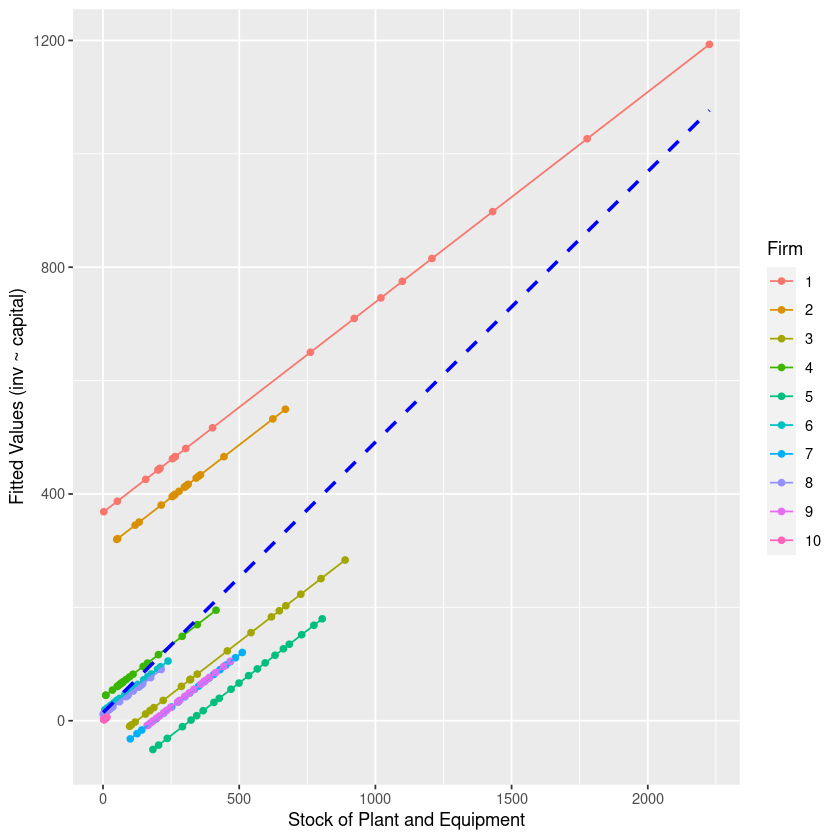

In [19]:
ggplot(data = broom::augment(fe_model_lm),
       aes(x = capital, y = .fitted)) +
  geom_point(aes(color = `factor(firm)`)) +
  geom_line(aes(color = `factor(firm)`)) +
  geom_line(data=broom::augment(pooled_ols_lm), 
            aes(x = capital, y =.fitted), 
            color = "blue", lty="dashed", size = 1) +
  labs(x = "Stock of Plant and Equipment", y = "Fitted Values (inv ~ capital)",
       color = "Firm") 

### Within-groups Estimator

The same coefficient estimates as with the LSDV approach can be computed with function plm(). The argument model= is now set to "within". This is the within estimator with n entity-specific intercepts.

In [18]:
fe_model_plm <- plm(inv ~ capital, data = Grunfeld, 
                    index = c("firm", "year"), 
                    effect = "individual", model = "within")

summary(fe_model_plm)

Oneway (individual) effect Within Model

Call:
plm(formula = inv ~ capital, data = Grunfeld, effect = "individual", 
    model = "within", index = c("firm", "year"))

Balanced Panel: n = 10, T = 20, N = 200

Residuals:
      Min.    1st Qu.     Median    3rd Qu.       Max. 
-190.71466  -20.83474   -0.45862   21.38262  293.68714 

Coefficients:
        Estimate Std. Error t-value  Pr(>|t|)    
capital 0.370750   0.019368  19.143 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    2244400
Residual Sum of Squares: 763680
R-Squared:      0.65973
Adj. R-Squared: 0.64173
F-statistic: 366.446 on 1 and 189 DF, p-value: < 2.22e-16

With function pFtest() one can test for fixed effects with the null hypothesis that pooled OLS is better than FE. Alternatively, this test can be carried out by jointly assessing the significance of the dummy variables in the LSDV approach. The results are identical.


In [20]:
# Within estimator vs. Pooled OLS
pFtest(fe_model_plm, pooled_ols_plm)


	F test for individual effects

data:  inv ~ capital
F = 123.39, df1 = 9, df2 = 189, p-value < 2.2e-16
alternative hypothesis: significant effects


###  First-difference Estimator

There is another way of estimating a FE model by specifying model = "fd" in function plm().

In [22]:
?plm

In [21]:
fe_model_fd<- plm(inv ~ capital -1, data = Grunfeld,
                  index = c("firm", "year"), 
                  effect = "individual", model = "fd")

summary(fe_model_fd)

Oneway (individual) effect First-Difference Model

Call:
plm(formula = inv ~ capital - 1, data = Grunfeld, effect = "individual", 
    model = "fd", index = c("firm", "year"))

Balanced Panel: n = 10, T = 20, N = 200
Observations used in estimation: 190

Residuals:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -240.4   -11.7     0.1     3.5    12.6   333.2 

Coefficients:
        Estimate Std. Error t-value Pr(>|t|)    
capital 0.230780   0.059639  3.8696  0.00015 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    584410
Residual Sum of Squares: 561210
R-Squared:      0.04476
Adj. R-Squared: 0.04476
F-statistic: 14.9739 on 1 and 189 DF, p-value: 0.00014998

### Random Effects Model

The RE model (also called Partial Pooling Model) assumes, in contrast to the FE model, that any variation between entities is random and not correlated with the regressors used in the estimation model. If there are reasons to believe that differences between entities influence the dependent variable, a RE model should be preferred. This also means that time-invariant variables (like a person’s gender) can be taken into account as regressors. The entity’s error term (unobserved heterogeneity) is hence not correlated with the regressors.

With RE models individual characteristics have to be specified if they have an influence on the other regressors. This poses the problem hat some variables need to be controlled for and might not be available, leading to omitted variable bias. Furthermore, the RE model allows for population inference from the sample because it assumes a normal distribution.

To break down the difference between FE and RE:

    the FE model assumes that an individual (entity) specific effect is correlated with the independent variables,

    while the RE model assumes that an individual (entity) specific effect is not correlated with the independent variables.


In [23]:
re_model_plm <- plm(inv ~ capital, data = Grunfeld, 
                    index = c("firm", "year"), 
                    effect = "individual", model = "random")

summary(re_model_plm)

Oneway (individual) effect Random Effect Model 
   (Swamy-Arora's transformation)

Call:
plm(formula = inv ~ capital, data = Grunfeld, effect = "individual", 
    model = "random", index = c("firm", "year"))

Balanced Panel: n = 10, T = 20, N = 200

Effects:
                   var  std.dev share
idiosyncratic  4040.63    63.57 0.135
individual    25949.52   161.09 0.865
theta: 0.9121

Residuals:
     Min.   1st Qu.    Median   3rd Qu.      Max. 
-164.0821  -22.2955   -3.7463   16.9121  319.9564 

Coefficients:
             Estimate Std. Error z-value Pr(>|z|)    
(Intercept) 43.246697  51.411319  0.8412   0.4002    
capital      0.372120   0.019316 19.2652   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    2299300
Residual Sum of Squares: 799910
R-Squared:      0.65211
Adj. R-Squared: 0.65036
Chisq: 371.149 on 1 DF, p-value: < 2.22e-16

The coefficients in the RE model include both the within-entity and between-entity effects. When having data with multiple entities and time periods the coefficient of capital represents the average effect on inv when capital changes across years and between firms by one unit.

The Breusch-Pagan Lagrange multiplier (LM) Test helps to decide between a random effects model and a simple OLS regression. This test is implemented in function plmtest() with the null hypothesis that the variance across entities is zero. In this setting this means that there are no significant differences across firms (no panel effect).

In [25]:
plmtest(pooled_ols_plm, effect = "individual", type = c("bp"))


	Lagrange Multiplier Test - (Breusch-Pagan)

data:  inv ~ capital
chisq = 1285.1, df = 1, p-value < 2.2e-16
alternative hypothesis: significant effects


The test shows that there are significant differences across firms. Running a pooled OLS regression is thus not appropriate and the RE model is the better choice.

A decision between a fixed and random effects model can be made with the Hausman test, which checks whether the individual error terms are correlated with the regressors. The null hypothesis states that there is no such correlation (RE). The alternative hypothesis is that a correlation exists (FE). The test is implemented in function phtest().

In [26]:
phtest(fe_model_plm, re_model_plm)


	Hausman Test

data:  inv ~ capital
chisq = 0.93423, df = 1, p-value = 0.3338
alternative hypothesis: one model is inconsistent


The null hypothesis cannot be rejected here, hence we should use a RE model.